# Goal: Priors on Transition Proba : Hospital given Symptoms


For the UNVACCINATED, based on a high-quality study from Spain in early '21, we will assume that our desired prior should have the following properties:

| Param Name                 | Mean/Mode    | 20-80 interval | 02-98 interval
| -------------------------- | ------------ | -------------- | ---------------
| p(hosp   &#124; symptom)   | 0.100        | 0.05 - 0.15    | 0.01 - 0.25


In [1]:
ideal_props = dict(
    p50=0.100, p20=0.050, p80=0.150, p02=0.010, p98=0.250,
    w50=1.000, w20=1.000, w80=1.000, w02=1.000, w98=1.000)

## Setup

In [2]:
import numpy as np
import scipy.stats
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
import viz_2d_gridsearch

In [7]:
import utils_pprint

In [8]:
import dist_beta

In [9]:
import dist_betamix

# Version 1: Simple Beta prior

Let's find the best Beta distribution that fits our constraints


At Level 0
-----------
xvar $\alpha$ grid has 10 elements
[0.001, 22.223111111111113, 44.44522222222222]
...
[155.5557777777778, 177.7778888888889, 200.0]
yvar $\beta$ grid has 10 elements
[0.001, 22.223111111111113, 44.44522222222222]
...
[155.5557777777778, 177.7778888888889, 200.0]

At Level 1
-----------
xvar $\alpha$ grid has 14 elements
[0.001, 3.4197863247863247, 6.83857264957265]
...
[37.60764957264957, 41.026435897435896, 44.44522222222222]
yvar $\beta$ grid has 14 elements
[111.11155555555555, 116.23973504273505, 121.36791452991453]
...
[167.52152991452994, 172.6497094017094, 177.7778888888889]

At Level 2
-----------
xvar $\alpha$ grid has 20 elements
[6.83857264957265, 7.378381016644175, 7.9181893837157]
...
[16.015314889788577, 16.5551232568601, 17.094931623931625]
yvar $\beta$ grid has 20 elements
[111.11155555555555, 111.38145973909131, 111.65136392262708]
...
[115.69992667566352, 115.96983085919929, 116.23973504273505]

At Level 3
-----------
xvar $\alpha$ grid has 28 

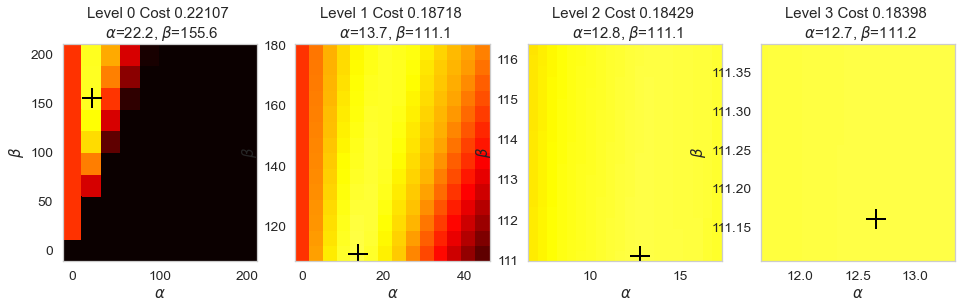

In [10]:
best_alpha, best_beta, best_cost = viz_2d_gridsearch.do_gridsearch_and_visualize(
    dist_beta.calc_cost,
    n_levels=4,
    xvar_name='$\\alpha$',
    yvar_name='$\\beta$',
    xvar_fmtstr='{:.1f}',
    yvar_fmtstr='{:.1f}',
    xvar_lims=(0.001, 200),
    yvar_lims=(0.001, 200),
    cost_kwargs=dict(random_state=0, size=100000, ideal_props=ideal_props),
    vmin=0.0,
    vmax=1.0)

In [11]:
S = 100000
samps_v1_S = dist_beta.sample(best_alpha, best_beta, size=S, random_state=1)
samps_v2_S = dist_beta.sample(best_alpha, best_beta, size=S, random_state=2)

In [12]:
df = utils_pprint.pprint_samples(samps_v1_S, samps_v2_S, ideal_props=ideal_props);

print("")
print(" Best cost: %.5f" % best_cost)
print("----------")
print(" best alpha: % 8.3f" % best_alpha)
print(" best beta : % 8.3f" % best_beta)

 perc  desired  observed1  observed2
  2.0     0.01      0.054      0.054
 20.0     0.05      0.079      0.079
 50.0     0.10      0.100      0.100
 80.0     0.15      0.124      0.124
 98.0     0.25      0.164      0.165

 Best cost: 0.18398
----------
 best alpha:   12.657
 best beta :  111.162


# Recall what a Beta(1.1, 1.1) looks like

Nearly uniform over the 0-1 interval, but just a little decay at the edges.

A priori, we do NOT think that our transition probability is extremely close to 0 or 1.

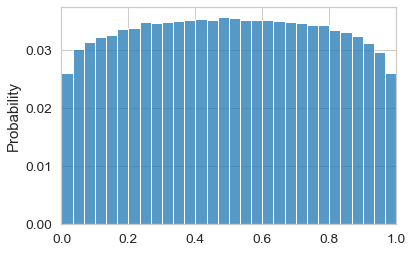

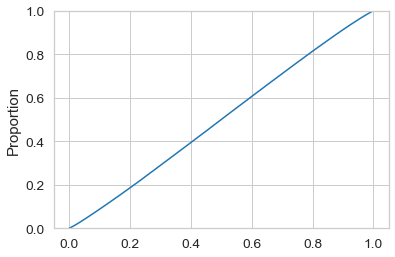

In [13]:
S = int(1e6)
m = 0.5
t = 2.2
samps_wide_S = dist_beta.sample(m * t, (1-m) * t, size=S, random_state=2)
sns.histplot(samps_wide_S, stat="probability", bins=np.linspace(0.0, 1.0, 31));
plt.xlim([0, 1])

plt.figure()
sns.ecdfplot(samps_wide_S);

# Version 2: Mixture-of-Betas prior

Try a MIXTURE of 

$$
w \cdot \text{Beta}( m * t, (1-m) *t) + (1-w) \text{Beta}(1.1, 1.1)
$$

Two free parameters:

* Total sum t (a positive scalar)
* Mixture weight w (in 0 to 1 interval)


At Level 0
-----------
xvar t grid has 10 elements
[0.1, 22.311111111111114, 44.522222222222226]
...
[155.57777777777778, 177.7888888888889, 200.0]
yvar w grid has 10 elements
[0.0001, 0.11118888888888889, 0.22227777777777777]
...
[0.7777222222222222, 0.8888111111111111, 0.9999]

At Level 1
-----------
xvar t grid has 14 elements
[0.1, 3.5170940170940175, 6.934188034188034]
...
[37.688034188034194, 41.10512820512821, 44.522222222222226]
yvar w grid has 14 elements
[0.7777222222222222, 0.7948128205128205, 0.8119034188034188]
...
[0.9657188034188035, 0.9828094017094018, 0.9999]

At Level 2
-----------
xvar t grid has 20 elements
[17.185470085470087, 17.72501124606388, 18.26455240665767]
...
[26.357669815564556, 26.897210976158348, 27.43675213675214]
yvar w grid has 20 elements
[0.9657188034188035, 0.9675178137651822, 0.969316824111561]
...
[0.9963019793072425, 0.9981009896536213, 0.9999]

At Level 3
-----------
xvar t grid has 28 elements
[24.73904633378318, 24.798995351626935, 24.85894

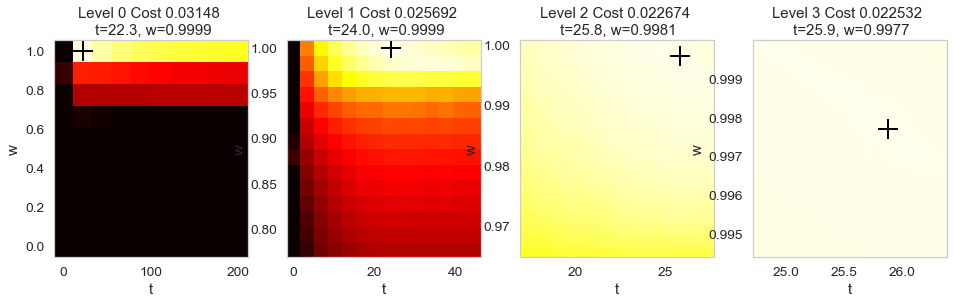

In [14]:
best_t, best_w, best_cost_betamix = viz_2d_gridsearch.do_gridsearch_and_visualize(
    dist_betamix.calc_cost,
    n_levels=4,
    xvar_name='t',
    yvar_name='w',
    xvar_fmtstr='{:.1f}',
    yvar_fmtstr='{:.4f}',
    xvar_lims=(0.1, 200),
    yvar_lims=(0.0001, 0.9999),
    cost_kwargs=dict(random_state=0, size=100000, ideal_props=ideal_props),
    vmin=0.0,
    vmax=1.0)

In [15]:
S = 100000
samps_v1_S = dist_betamix.sample(best_t, best_w, size=S, random_state=1, ideal_props=ideal_props)
samps_v2_S = dist_betamix.sample(best_t, best_w, size=S, random_state=2, ideal_props=ideal_props)

In [16]:
df = utils_pprint.pprint_samples(samps_v1_S, samps_v2_S, ideal_props=ideal_props);

print("")
print(" Best cost: %.5f" % best_cost_betamix)
print("----------")
print(" best t: % 8.3f" % best_t)
print(" best w: % 8.3f" % best_w)
print(" best m: % 8.3f" % ideal_props['p50'])

 perc  desired  observed1  observed2
  2.0     0.01      0.017      0.017
 20.0     0.05      0.050      0.050
 50.0     0.10      0.090      0.090
 80.0     0.15      0.145      0.145
 98.0     0.25      0.251      0.250

 Best cost: 0.02253
----------
 best t:   25.878
 best w:    0.998
 best m:    0.100


# Visual of chosen prior distribution

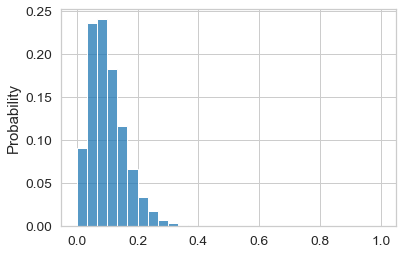

In [17]:
sns.histplot(samps_v1_S, stat="probability", bins=np.linspace(0.0, 1.0, 31));

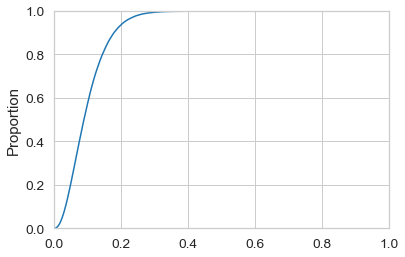

In [18]:
sns.ecdfplot(samps_v1_S);
plt.xlim([0.0, 1.0]);